## Практическая работа "VAE"
### Выполнил: Сидельников Дэвид Константинович, группа КЭ-228

1. История Н. Кодера и Д. Кодера
2. Автоэнкодер на MNIST
3. Рисуем скрытое пространство
4. Сгенерим из пространства изображение
5. VAE и его скрытое пространство
6. Операции с латентными векторами

In [2]:
from IPython.display import Image

![title](/Users/davidlimcher/Desktop/Python/nowadays/synthetic_media/practice_1/autoencoder.png)

In [5]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import tqdm

В этом блоке кода подключаются все необходимые библиотеки, а также определяется устройство, на котором будет производиться выполнение (CPU или GPU, если доступен).

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### Создание классов для стандартного автоэнкодера:

+ Encoder: кодирует изображение в латентное пространство.
+ Decoder: восстанавливает изображение из латентного пространства.
+ Autoencoder: объединяет оба класса для полной модели автоэнкодера.

In [7]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [8]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [9]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

### Функция для тренировки автоэнкодера на наборе данных MNIST.
Оптимизация модели происходит с использованием оптимизатора Adam, а в качестве функции потерь используется сумма квадратов разностей между оригинальными и реконструированными изображениями.

In [10]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm.tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

Создание объекта автоэнкодера с латентным пространством размером 2 и его обучение на наборе данных MNIST. Обучение проводится на разных количествах эпох (1, 5 и 10), чтобы увидеть динамику обучения.

In [11]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device) # GPU

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

In [12]:
autoencoder_1 = train(autoencoder, data, epochs=1)
autoencoder_5 = train(autoencoder, data, epochs=5)
autoencoder_10 = train(autoencoder, data, epochs=10) 

100%|██████████| 10/10 [00:38<00:00,  3.85s/it]


В этом блоке происходит построение изображений из латентного пространства. Функция plot_reconstructed генерирует изображения, соответствующие точкам в латентном пространстве, и визуализирует их в виде матрицы.

In [13]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

Функция для визуализации латентного пространства. Она принимает автоэнкодер и данные, и выводит скрытые представления данных в двумерной плоскости, окрашивая точки в соответствии с метками изображений.

In [14]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

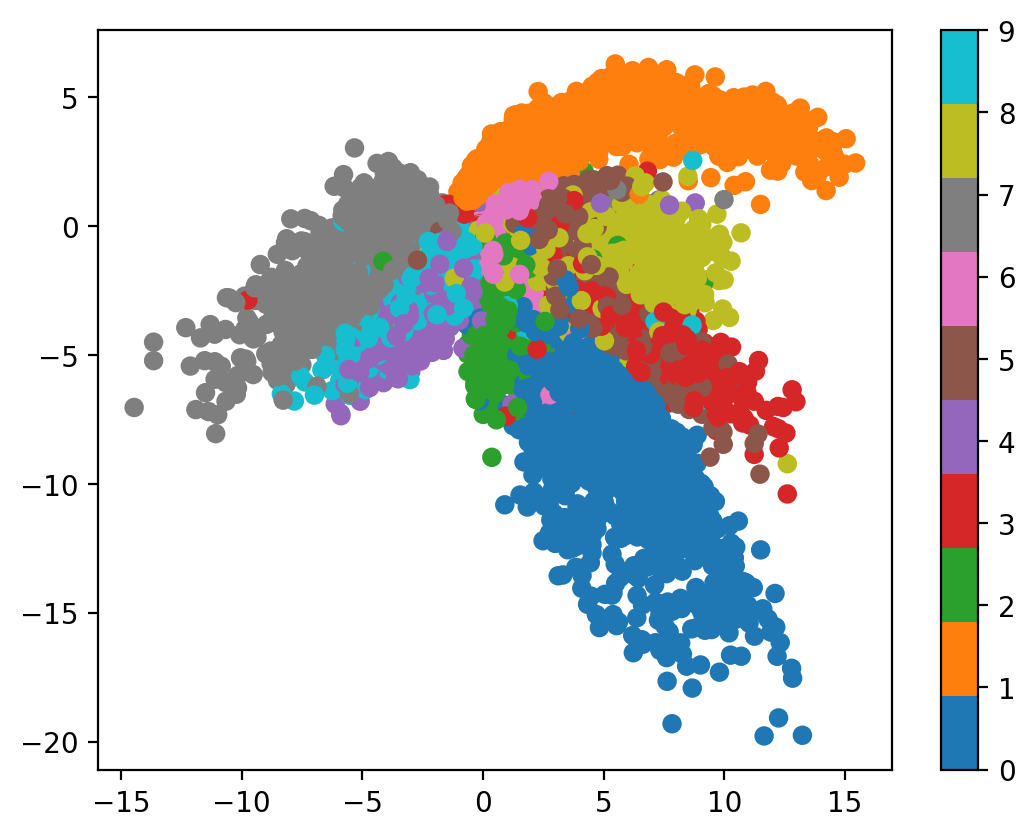

In [15]:
plot_latent(autoencoder_1, data)

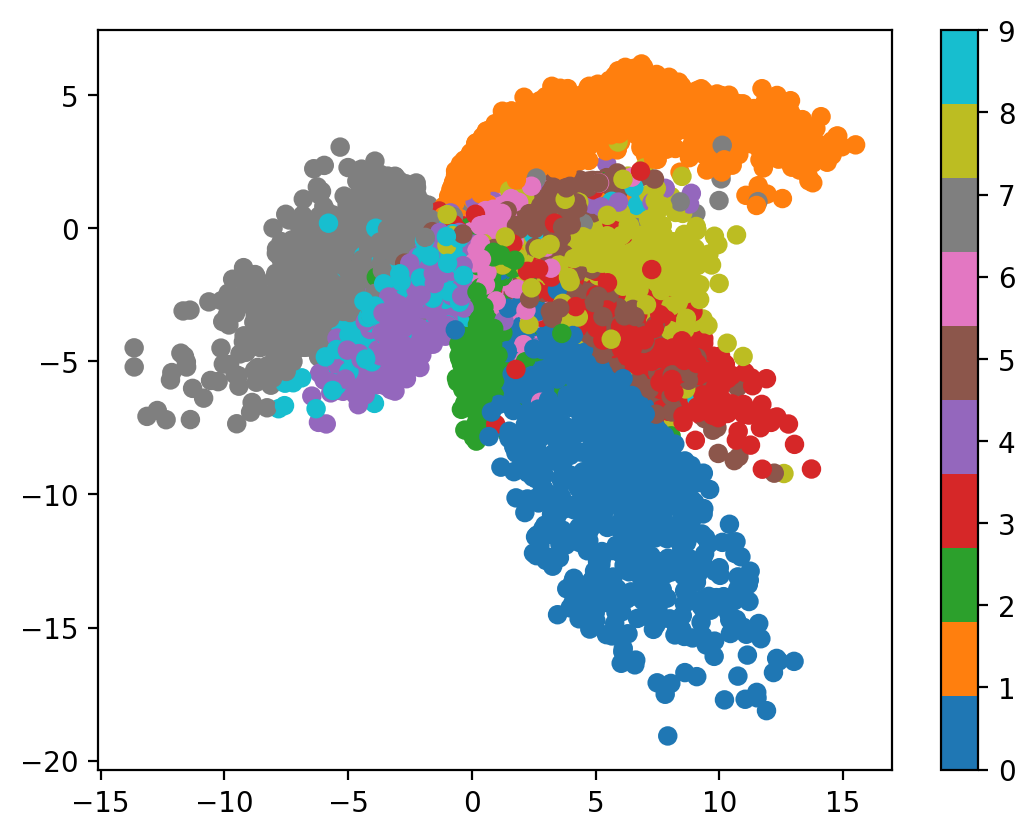

In [16]:
plot_latent(autoencoder_5, data)

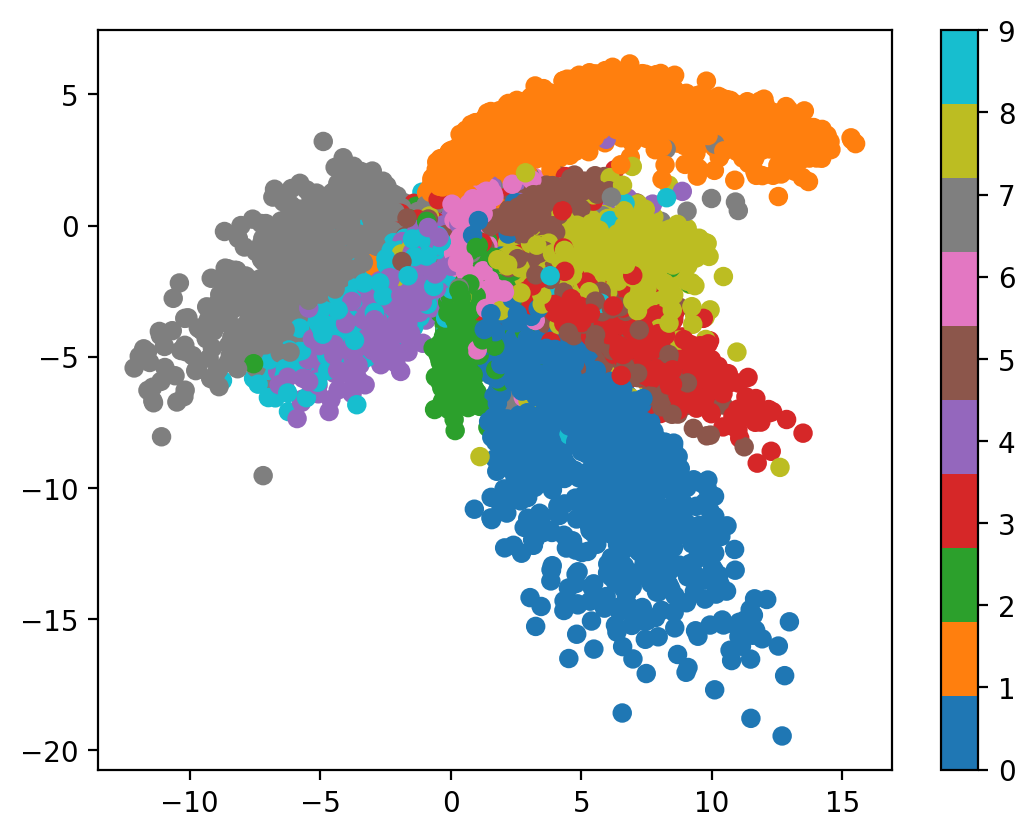

In [17]:
plot_latent(autoencoder_10, data)

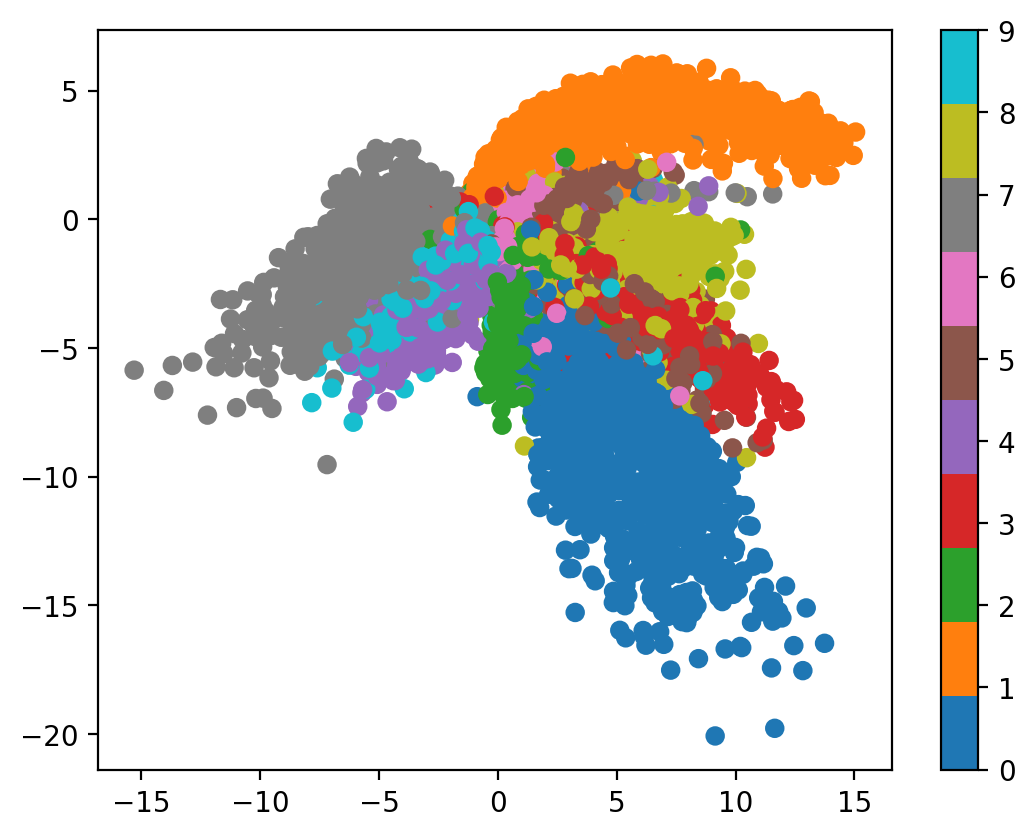

In [18]:
plot_latent(autoencoder, data)

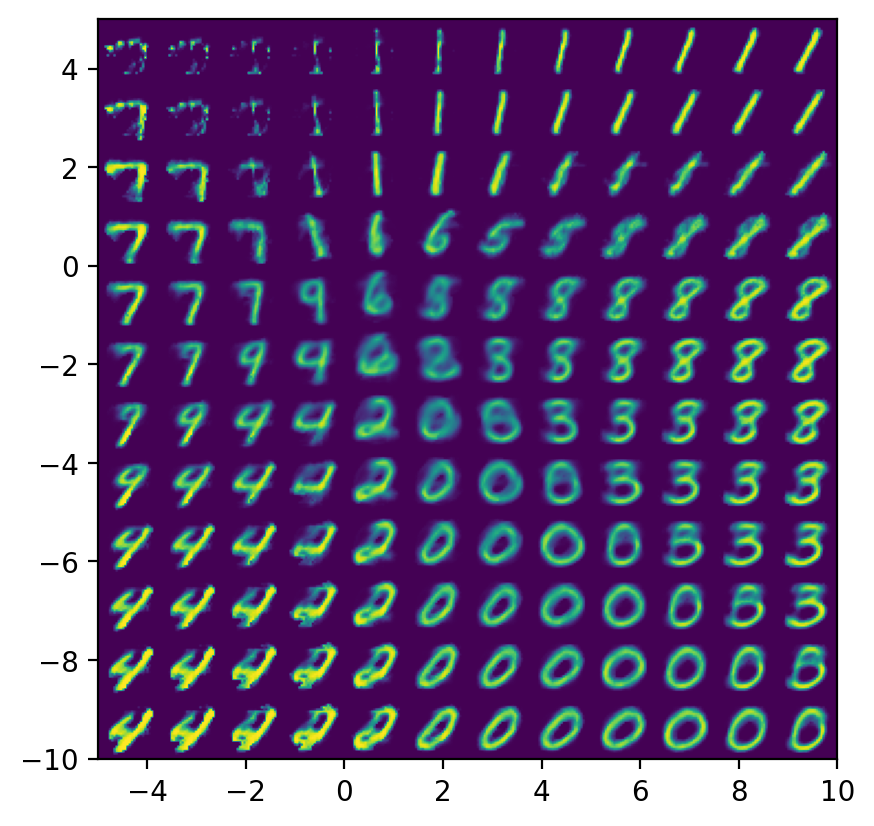

In [19]:
plot_reconstructed(autoencoder)

![title](/Users/davidlimcher/Desktop/Python/nowadays/synthetic_media/practice_1/VAE.png)

![title](/Users/davidlimcher/Desktop/Python/nowadays/synthetic_media/practice_1/kl_div.png)

Здесь создается вариационный автоэнкодер (VAE). Основное отличие в том, что кодировщик теперь выдает не фиксированные значения, а параметры распределения (среднее и стандартное отклонение). Для выборки используется нормальное распределение, и добавляется регуляризационный член KL-дивергенции.

In [33]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        #self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        #self.N.scale = self.N.scale.cuda()
        self.N.loc = self.N.loc # hack to get sampling on the GPU
        self.N.scale = self.N.scale
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

Создается полный вариационный автоэнкодер (VAE), который объединяет вариационный кодировщик и обычный декодировщик для работы с латентными переменными.

In [34]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

Обучение вариационного автоэнкодера происходит по аналогии с обычным автоэнкодером, но в функцию потерь добавляется KL-дивергенция, которая является регуляризатором.

In [35]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm.tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [36]:
vae = VariationalAutoencoder(latent_dims).to(device)
vae = train(vae, data)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [01:18<00:00,  3.91s/it]


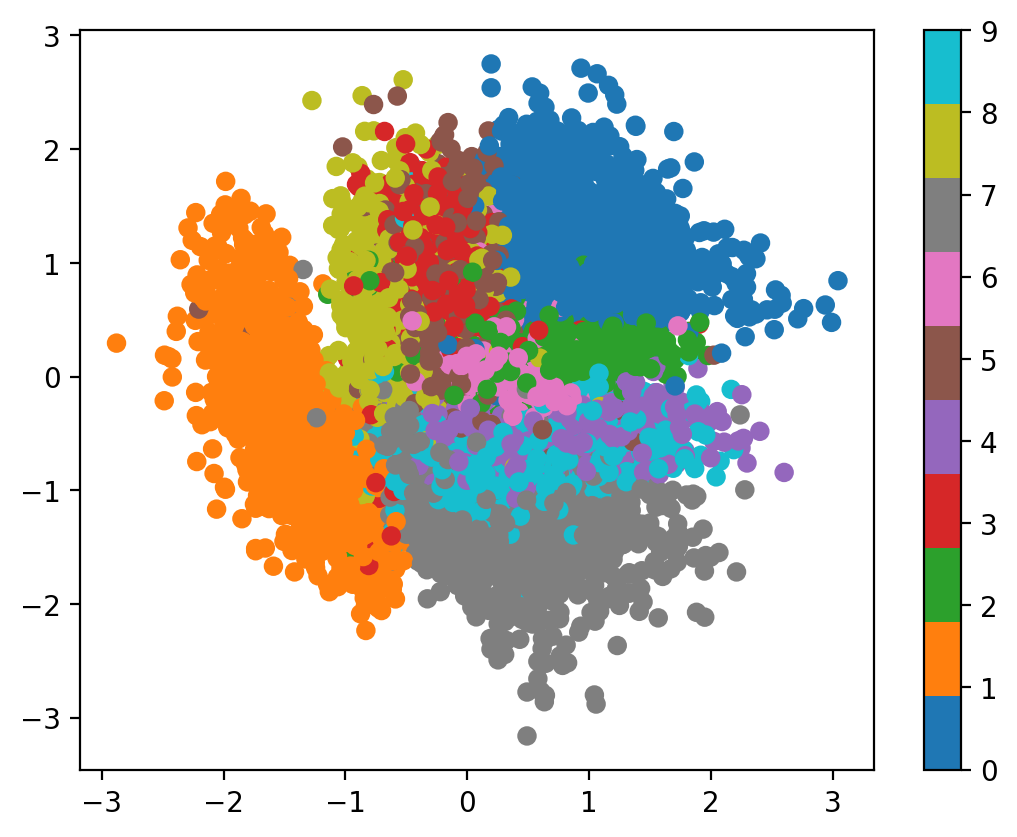

In [37]:
plot_latent(vae, data)

Функция interpolate создает интерполяцию (плавный переход) между двумя изображениями в латентном пространстве с помощью автоэнкодера. Интерполяция осуществляется путем выборки промежуточных точек между двумя латентными представлениями (векторами) этих изображений. Функция визуализирует результаты в виде изображений, которые постепенно трансформируются из одного в другое.

In [38]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [39]:
x, y = next(iter(data)) # hack to grab a batch
x_1 = x[y == 3][0].to(device) # find a 1
x_2 = x[y == 7][0].to(device) # find a 0

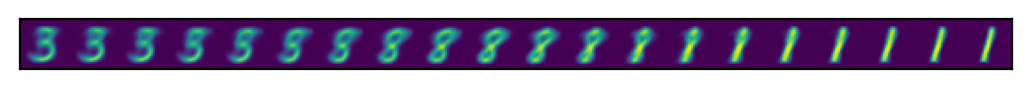

In [40]:
interpolate(vae, x_1, x_2, n=20)

Функция для создания анимации (GIF), показывающей интерполяцию между двумя изображениями в латентном пространстве. Генерируется ряд изображений, которые постепенно переходят от одного к другому.

In [41]:
from PIL import Image

def interpolate_gif(autoencoder, filename, x_1, x_2, n=100):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)

    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])

    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()*255

    images_list = [Image.fromarray(img.reshape(28, 28)).resize((256, 256)) for img in interpolate_list]
    images_list = images_list + images_list[::-1] # loop back beginning

    images_list[0].save(
        f'{filename}.gif',
        save_all=True,
        append_images=images_list[1:],
        loop=1)

In [42]:
interpolate_gif(vae, "vae", x_1, x_2)